In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
from pyspark.sql.types import NumericType
import csv
import numpy as np
from matplotlib.animation import FuncAnimation

In [4]:
# Crear o recuperar una sesión de Spark
spark = SparkSession.builder \
    .appName("CorrExample") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.python.worker.memory", "4g") \
    .getOrCreate()

# Verificar la versión de Spark
print(f"Versión de Spark: {spark.version}")

# Finalizar la sesión (cuando termines)
# spark.stop()

Versión de Spark: 3.5.4


------------------------------



# **Introduction**

![Life Expentancy](img/LE.jpg)

Life expectancy prognosing is a complex and multifaceted problem that involves analyzing a wide range of factors that can influence a person's lifespan. From a substantive point of view, there are several key considerations that must be taken into account when attempting to accurately predict life expectancy.

It is important to recognize that life expectancy is not a fixed value that is determined solely by genetics or other inherent factors. Rather, it is influenced by a wide range of environmental, social, and behavioral factors that can vary significantly across different populations and individuals. For example, access to healthcare, nutrition, and clean water can all have a significant impact on life expectancy, as can lifestyle factors such as smoking, alcohol consumption, and physical activity levels.


Life expectancy prognosing can have significant implications for both individuals and society as a whole. Accurate life expectancy forecasts can help individuals make important decisions about their healthcare, financial planning, and retirement, while also providing policymakers with valuable information about population health and healthcare needs.


Overall, the problem in question requires a deep understanding of a wide range of social, environmental, and behavioral factors. By taking a substantive approach to this problem and carefully considering all of the relevant factors, we can develop more accurate and useful life expectancy forecasts that can help individuals and society make better-informed decisions about health and well-being.

---------------------
# **Data Explanation:**

TARGET: "Life Expectancy"



1. Country - List of the 179 countries
2. Region - 179 countries are distributed in 9 regions. E.g. Africa, Asia, Oceania, European Union, Rest of Europe and etc.
3. Year - Years observed from 2000 to 2015
4. Infant_deaths - Represents infant deaths per 1000 population
5. Under_five_deaths - Represents deaths of children under five years old per 1000 population
6. Adult_mortality - Represents deaths of adults per 1000 population
7. Alcohol_consumption - Represents alcohol consumption that is recorded in liters of pure alcohol per capita with 15+ years old
8. Hepatitis_B - Represents % of coverage of Hepatitis B (HepB3) immunization among 1-year-olds.
9. Measles - Represents % of coverage of Measles containing vaccine first dose (MCV1) immunization among 1-year-olds
10. BMI- BMI is a measure of nutritional status in adults. It is defined as a person's weight in kilograms divided by the square of that person's height in meters (kg/m2)
11. Polio - Represents % of coverage of Polio (Pol3) immunization among 1-year-olds.
12. Diphtheria - Represents % of coverage of Diphtheria tetanus toxoid and pertussis (DTP3) immunization among 1-year-olds.
13. Incidents_HIV - Incidents of HIV per 1000 population aged 15-49
14. GDP_per_capita - GDP per capita in current USD
15. Population_mln - Total population in millions
16. Thinness_ten_nineteen_years - Prevalence of thinness among adolescents aged 10-19 years. BMI < -2 standard deviations below the median.
17. Thinness_five_nine_years - Prevalence of thinness among children aged 5-9 years. BMI < -2 standard deviations below the median.
18. Schooling - Average years that people aged 25+ spent in formal education
19. Economy_status_Developed - Developed country
20. Economy_status_Developing - Developing country
21. Life_expectancy - Average life expectancy for both genders in different years from 2010 to 2015

# **Report**

## **Problem:** prediction of life expectancy, based on the key country features and recognition of key factors influencing the target 
**Date:** 03-02-2025

**Author:** Dionicio Pérez ([LinkedIn](https://www.linkedin.com/in/dionicio-alberto/))

### **Aproach**
**Chosen model:**

Linear Regresion
Decission Tree Regression

### **Tools and Libreries**
- PySpark
- Pandas
- Matplotlib
- Seaborn


---------

# **Data Explorer**

## Load and Read Dataset

In [70]:
Life_expectancy = pd.read_csv(
    filepath_or_buffer="../data/raw/LIFE.csv"
)

In [5]:
dataset = spark.read.csv(
    path="../data/raw/LIFE.csv",
    header=True,
    inferSchema=True)

In [6]:
dataset.show()

+------------------+--------------------+----+-------------+-----------------+---------------+-------------------+-----------+-------+----+-----+----------+-------------+--------------+--------------+---------------------------+------------------------+---------+------------------------+-------------------------+---------------+
|           Country|              Region|Year|Infant_deaths|Under_five_deaths|Adult_mortality|Alcohol_consumption|Hepatitis_B|Measles| BMI|Polio|Diphtheria|Incidents_HIV|GDP_per_capita|Population_mln|Thinness_ten_nineteen_years|Thinness_five_nine_years|Schooling|Economy_status_Developed|Economy_status_Developing|Life_expectancy|
+------------------+--------------------+----+-------------+-----------------+---------------+-------------------+-----------+-------+----+-----+----------+-------------+--------------+--------------+---------------------------+------------------------+---------+------------------------+-------------------------+---------------+
|      

In [7]:
dataset.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Infant_deaths: double (nullable = true)
 |-- Under_five_deaths: double (nullable = true)
 |-- Adult_mortality: double (nullable = true)
 |-- Alcohol_consumption: double (nullable = true)
 |-- Hepatitis_B: integer (nullable = true)
 |-- Measles: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Polio: integer (nullable = true)
 |-- Diphtheria: integer (nullable = true)
 |-- Incidents_HIV: double (nullable = true)
 |-- GDP_per_capita: integer (nullable = true)
 |-- Population_mln: double (nullable = true)
 |-- Thinness_ten_nineteen_years: double (nullable = true)
 |-- Thinness_five_nine_years: double (nullable = true)
 |-- Schooling: double (nullable = true)
 |-- Economy_status_Developed: integer (nullable = true)
 |-- Economy_status_Developing: integer (nullable = true)
 |-- Life_expectancy: double (nullable = true)



## Matriz de Correlacion
Vamos a generar la matriz de correlacion usando pyspark, a diferencia de pandas, incluye de forma nativa esta funcion para todas los columnas, únicamente entre dos columnas, por lo cual haremos lo siguiente:

1. Obtener el nombre de las oclumnas numericas
2. Obtener la informacion de la matriz de correlacion en un diccionario
3. Convertir el diccionario a una matriz de correlacion

En este caso, hemos necesitado un paso extra, por problems con el spark, por lo que escribimos el archivo en csv y lo cargamos para leerlo

### Fórmula de la Correlación de Pearson
$$
r = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}
{\sqrt{\sum_{i=1}^{n} (x_i - \bar{x})^2} \sqrt{\sum_{i=1}^{n} (y_i - \bar{y})^2}}
$$

### Explicación

La **correlación de Pearson** $ r $ mide la **fuerza** y **dirección** de la relación lineal entre dos variables $ X $ y $ Y $.

- $ x_i $ y $ y_i $: Valores individuales de las variables $ X $ y $ Y $.
- $ \bar{x} $ y $ \bar{y} $: Medias (promedios) de las variables $ X $ y $ Y $, respectivamente.
- $ n $: Número total de observaciones.

### Interpretación del valor de $ r $

- **$ r = 1 $**: Correlación positiva perfecta (ambas variables aumentan juntas).
- **$ r = -1 $**: Correlación negativa perfecta (una variable aumenta mientras la otra disminuye).
- **$ r = 0 $**: No hay correlación lineal entre las variables.

### Ejemplo de Interpretación

| Valor de $ r $  | Interpretación                    |
|-------------------|----------------------------------|
| 0.7 a 1.0         | Correlación fuerte positiva       |
| 0.3 a 0.7         | Correlación moderada positiva     |
| 0.0 a 0.3         | Correlación débil positiva        |
| -0.3 a 0.0        | Correlación débil negativa        |
| -0.7 a -0.3       | Correlación moderada negativa     |
| -1.0 a -0.7       | Correlación fuerte negativa       |

Este coeficiente es muy útil para identificar relaciones lineales, pero no detecta relaciones no lineales.

In [37]:
numeric_columns = [field.name for field in dataset.schema.fields if isinstance(field.dataType, NumericType)]

In [38]:
# Calcular la correlación entre todas las columnas numéricas
correlation_matrix = {}

for i in range(len(numeric_columns)):
    for j in range(i+1, len(numeric_columns)):
        col1 = numeric_columns[i]
        col2 = numeric_columns[j]
        correlation = dataset.corr(col1, col2)
        correlation_matrix[(col1, col2)] = correlation

In [42]:
# Obtener todas las variables únicas
variables = set()
for var1, var2 in correlation_matrix.keys():
    variables.add(var1)
    variables.add(var2)

variables = sorted(list(variables))  # Ordenar las variables alfabéticamente

# Crear una lista para almacenar los datos en formato de tabla
data = []
for variable in variables:
    row = [variable]  # La primera columna es el nombre de la variable
    for other_variable in variables:
        # Buscar la correlación correspondiente en el diccionario
        if (variable, other_variable) in correlation_matrix:
            correlation = correlation_matrix[(variable, other_variable)]
        elif (other_variable, variable) in correlation_matrix: # Check for reverse order
            correlation = correlation_matrix[(other_variable, variable)]
        else:
            correlation = ""  # Dejar en blanco si no hay correlación
        row.append(correlation)
    data.append(row)

# Escribir los datos en un archivo CSV
with open("../data/Generated/correlation_matrix2.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Variable"] + variables)  # Escribir la fila de encabezado
    writer.writerows(data)  # Escribir los datos

Cargamos con spark y posteriormente vamos a visualizar con Seaborn

In [55]:
correlation_matrix_df = spark.read.csv(
    path="../data/Generated/correlation_matrix.csv",
    header="true",
    inferSchema=True)

In [56]:
correlation_matrix_df.printSchema()

root
 |-- Variable: string (nullable = true)
 |-- Adult_mortality: double (nullable = true)
 |-- Alcohol_consumption: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Diphtheria: double (nullable = true)
 |-- Economy_status_Developed: double (nullable = true)
 |-- Economy_status_Developing: double (nullable = true)
 |-- GDP_per_capita: double (nullable = true)
 |-- Hepatitis_B: double (nullable = true)
 |-- Incidents_HIV: double (nullable = true)
 |-- Infant_deaths: double (nullable = true)
 |-- Life_expectancy: double (nullable = true)
 |-- Measles: double (nullable = true)
 |-- Polio: double (nullable = true)
 |-- Population_mln: double (nullable = true)
 |-- Schooling: double (nullable = true)
 |-- Thinness_five_nine_years: double (nullable = true)
 |-- Thinness_ten_nineteen_years: double (nullable = true)
 |-- Under_five_deaths: double (nullable = true)
 |-- Year: double (nullable = true)



In [60]:
correlation_matrix_pd = correlation_matrix_df.toPandas().set_index("Variable")

<Axes: ylabel='Variable'>

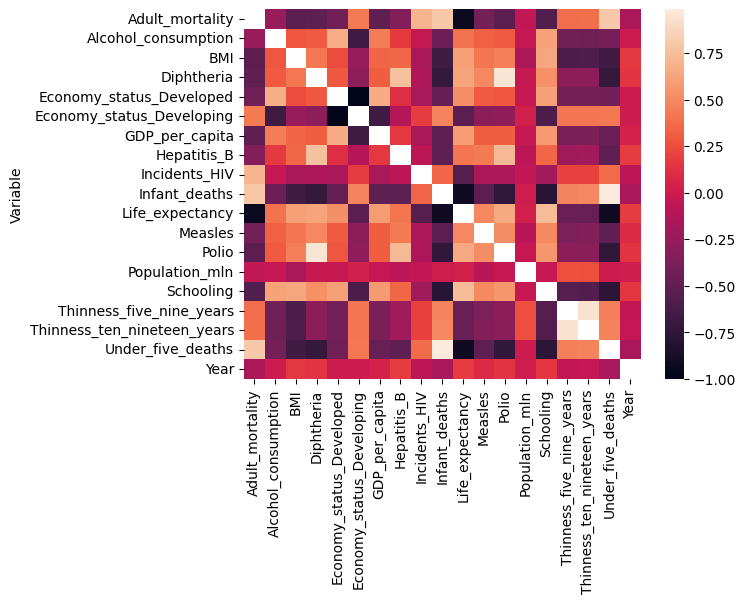

In [59]:
sns.heatmap(correlation_matrix_pd)

En este caso, necesitamos transformar la información a un dataframe de pandas para generar la matriz de correlacion. 
Continuaremos con la exploración de los datos, para esto usaremos pandas debido a su practicidad, posteriormente regresaremos a spark.

En la matriz de correlacion podemos observar que existen variables que estan relacionadas linealmente entre ellas, dejaremos unicamente aquellas que tengan una correlacion mayor a $\| 0.6 \|$ 

<Axes: ylabel='Variable'>

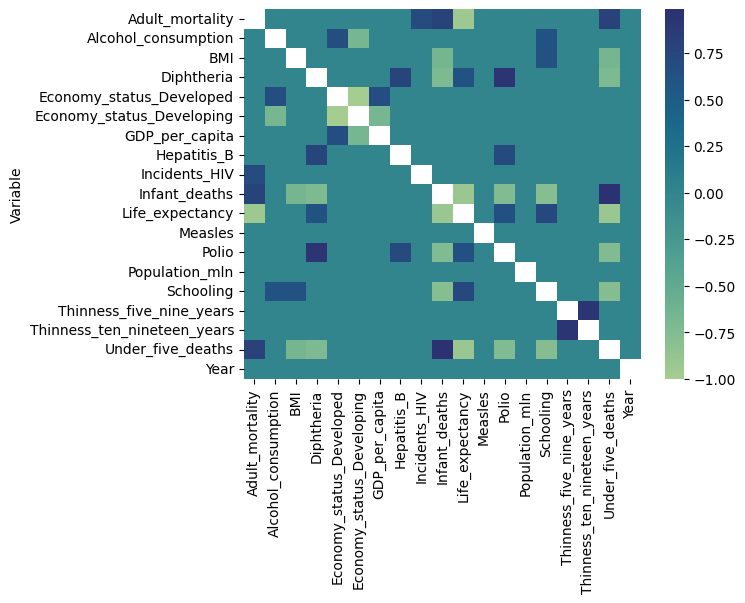

In [69]:
sns.heatmap(correlation_matrix_pd.map(lambda x: 0 if -0.6 < x < 0.6 else x), cmap="crest")


## Esperanza de vida

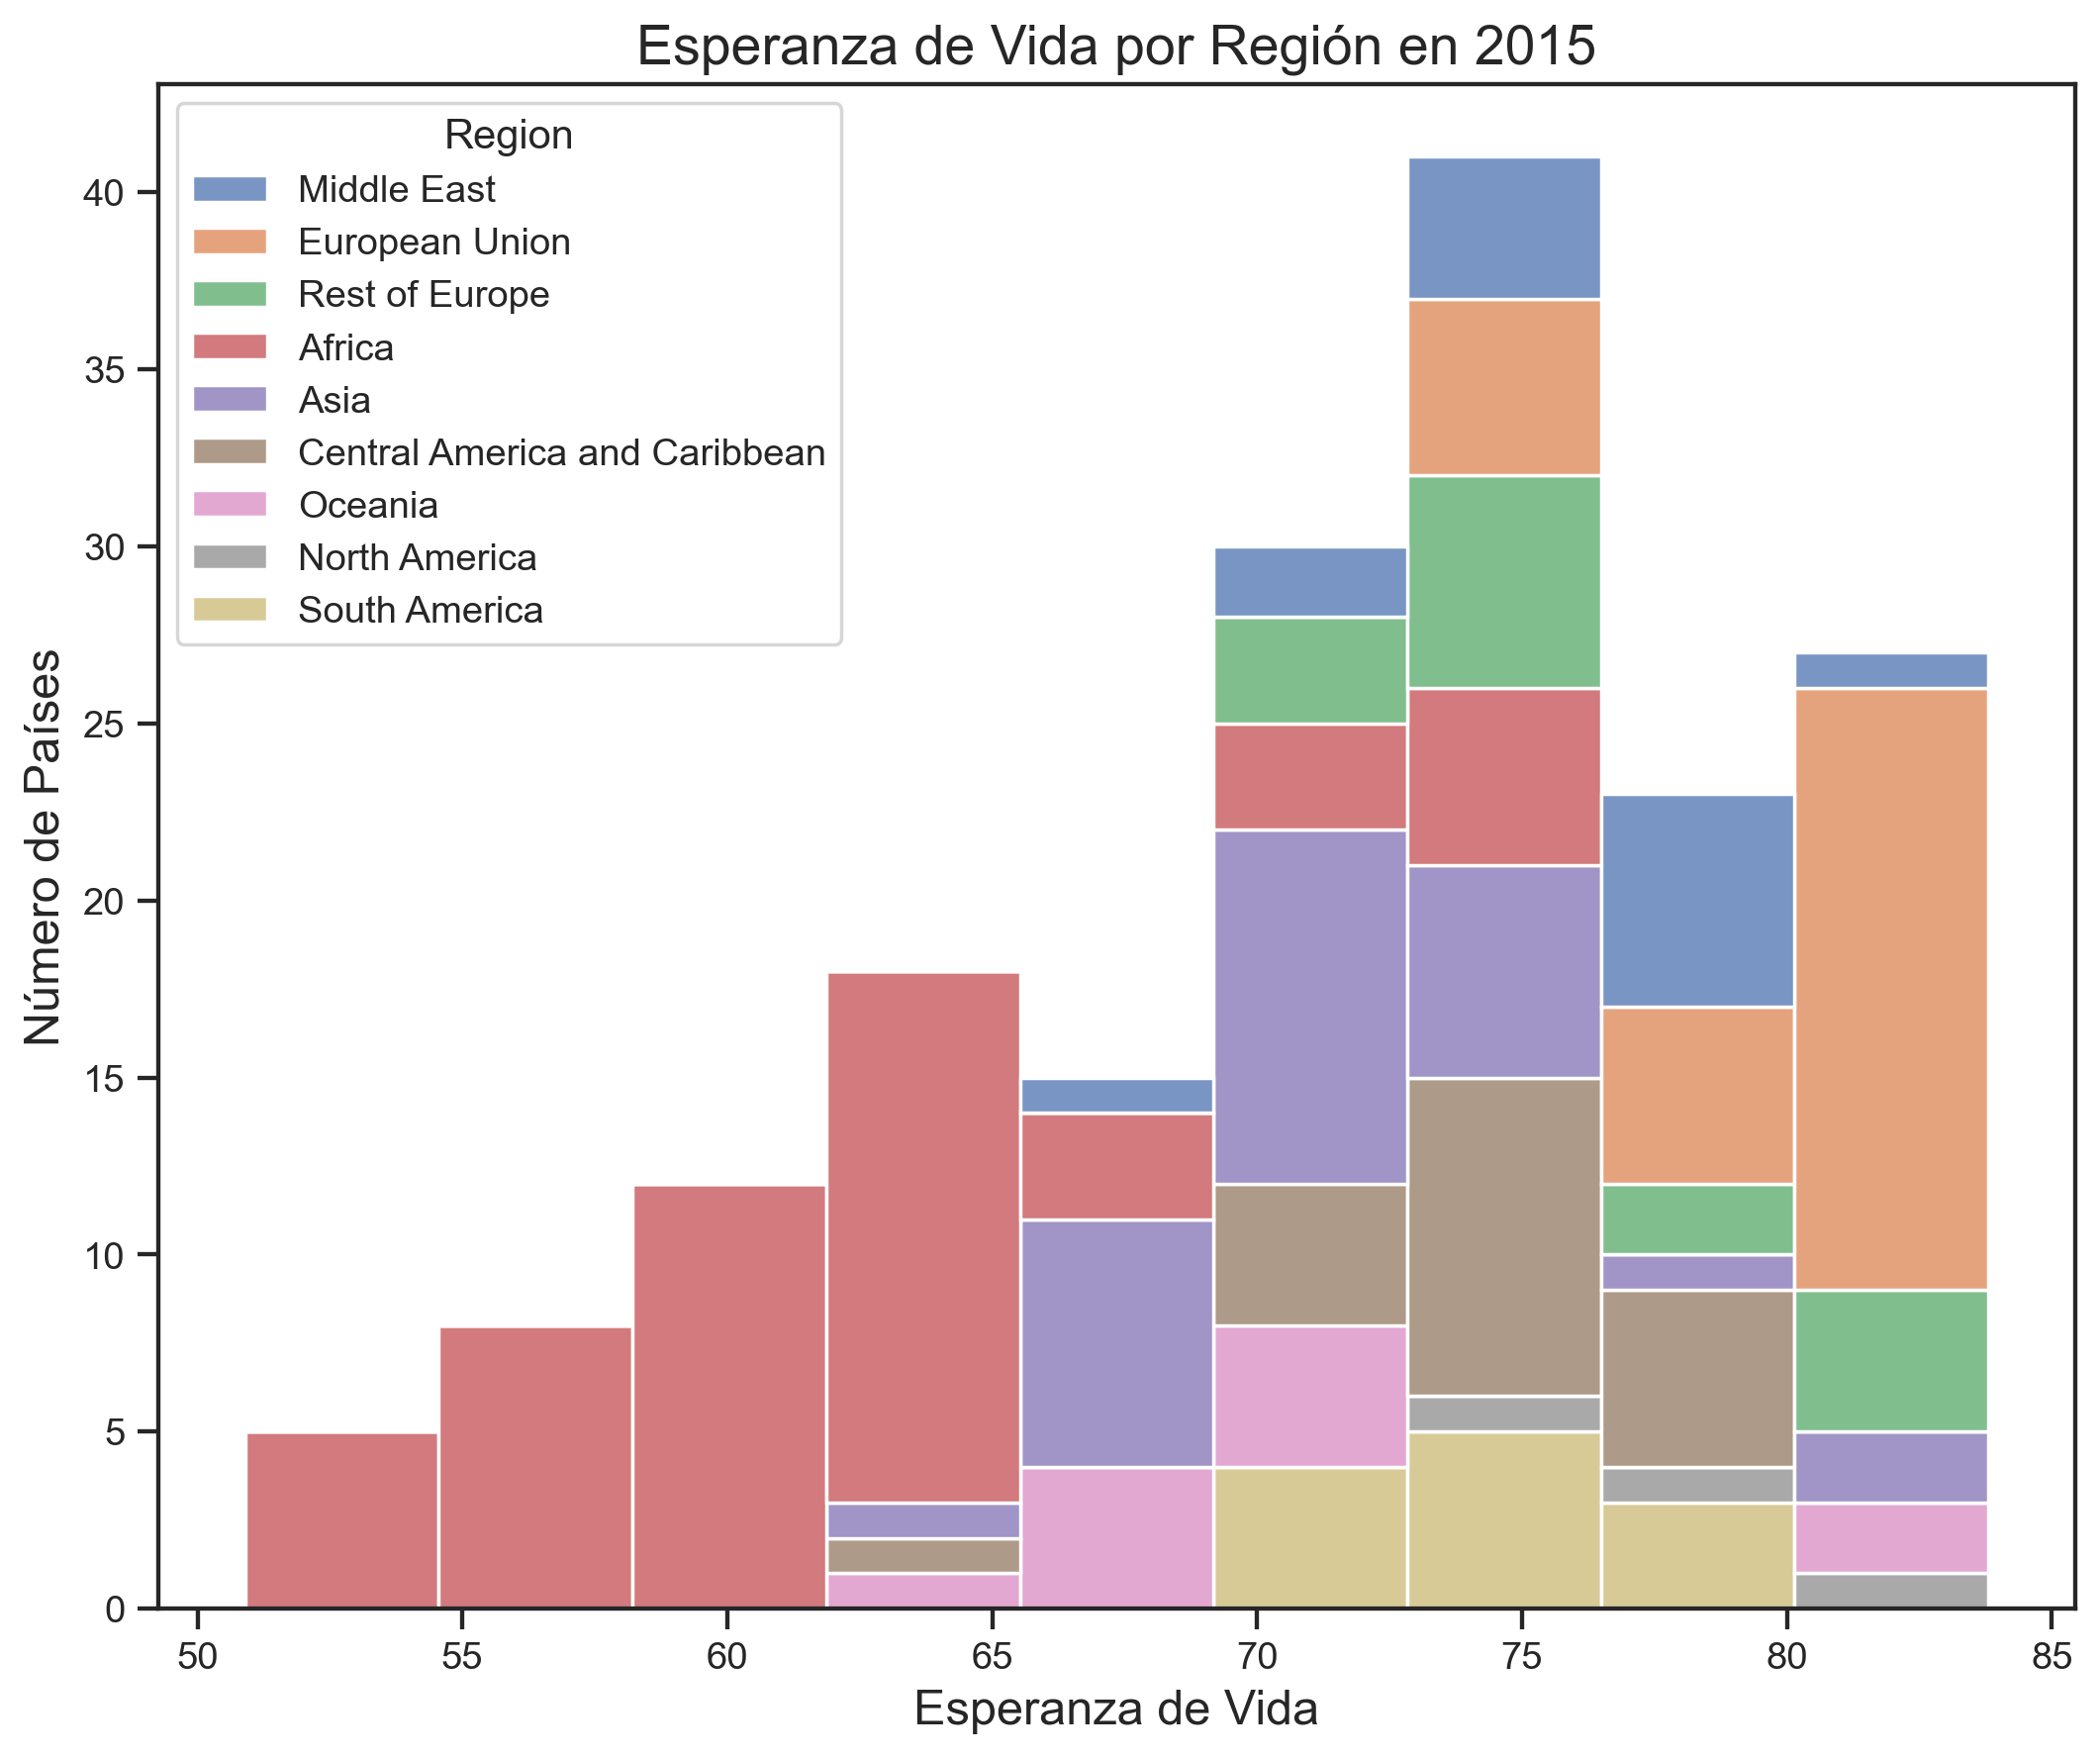

In [124]:
# Configurar el tema de Seaborn
sns.set_theme(style='ticks')

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 8), dpi=250)

# Crear el histograma en el eje ax
sns.histplot(
    x='Life_expectancy', 
    data=Life_expectancy[Life_expectancy["Year"] == 2015],
    color='#eb612a',
    hue="Region",
    multiple="stack",
    ax=ax  # Aquí se asigna el gráfico al eje
)

# Personalización del gráfico usando el eje ax
ax.set_title('Esperanza de Vida por Región en 2015', fontsize=16)
ax.set_xlabel('Esperanza de Vida', fontsize=14)
ax.set_ylabel('Número de Países', fontsize=14)

# Mostrar el gráfico
plt.show()

En este grafico mostramos como esta distribuida la esperanza de vida en el año 2015, a continuacion se muestra como ha evolucionado con los años

In [96]:
data = Life_expectancy.copy()
# Obtener los años únicos para la animación
years = sorted(data['Year'].unique())

Index(['Country', 'Region', 'Year', 'Infant_deaths', 'Under_five_deaths',
       'Adult_mortality', 'Alcohol_consumption', 'Hepatitis_B', 'Measles',
       'BMI', 'Polio', 'Diphtheria', 'Incidents_HIV', 'GDP_per_capita',
       'Population_mln', 'Thinness_ten_nineteen_years',
       'Thinness_five_nine_years', 'Schooling', 'Economy_status_Developed',
       'Economy_status_Developing', 'Life_expectancy'],
      dtype='object')


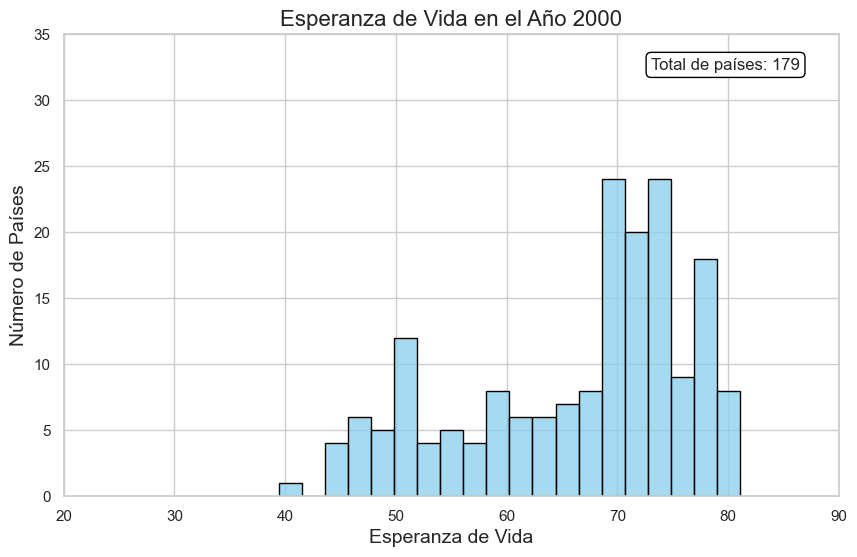

In [127]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# 2. Verificar los nombres de las columnas
print(data.columns)  # Verifica que las columnas sean correctas

# 3. Limpiar espacios en los nombres de las columnas si es necesario
data.columns = data.columns.str.strip()

# 4. Configurar el estilo de Seaborn para hacer gráficos más estéticos
sns.set_theme(style="whitegrid")

# 5. Crear la figura para la animación
fig, ax = plt.subplots(figsize=(10, 6))

# 6. Función para actualizar el histograma en cada cuadro de la animación
def update(year):
    ax.clear()  # Limpia el gráfico para dibujar el siguiente año
    yearly_data = data[data['Year'] == year]['Life_expectancy']  # Filtra la esperanza de vida para el año actual
    
    # Crear el histograma usando Seaborn
    sns.histplot(yearly_data, bins=20, kde=False, color='skyblue', edgecolor='black', ax=ax)
    
    # Personalización del gráfico
    ax.set_title(f'Esperanza de Vida en el Año {year}', fontsize=16)
    ax.set_xlabel('Esperanza de Vida', fontsize=14)
    ax.set_ylabel('Número de Países', fontsize=14)
    ax.set_xlim(20, 90)  # Ajusta según tu rango de datos
    ax.set_ylim(0, 35)
    
    # Mostrar la cantidad total de países en el año actual
    total_countries = yearly_data.count()
    ax.text(0.95, 0.95, f'Total de países: {total_countries}', transform=ax.transAxes,
            fontsize=12, ha='right', va='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

# 7. Obtener el rango de años únicos en los datos
years = sorted(data['Year'].unique())

# 8. Crear la animación
anim = FuncAnimation(fig, update, frames=years, interval=500)

# 9. Guardar la animación como un archivo GIF o MP4
anim.save('../data/Generated/life_expectancy_histogram.gif', writer='pillow')
# Si prefieres un MP4, descomenta la siguiente línea
# anim.save('life_expectancy_histogram.mp4', writer='ffmpeg')


![Histogrma Historico](../data/Generated/life_expectancy_histogram.gif)

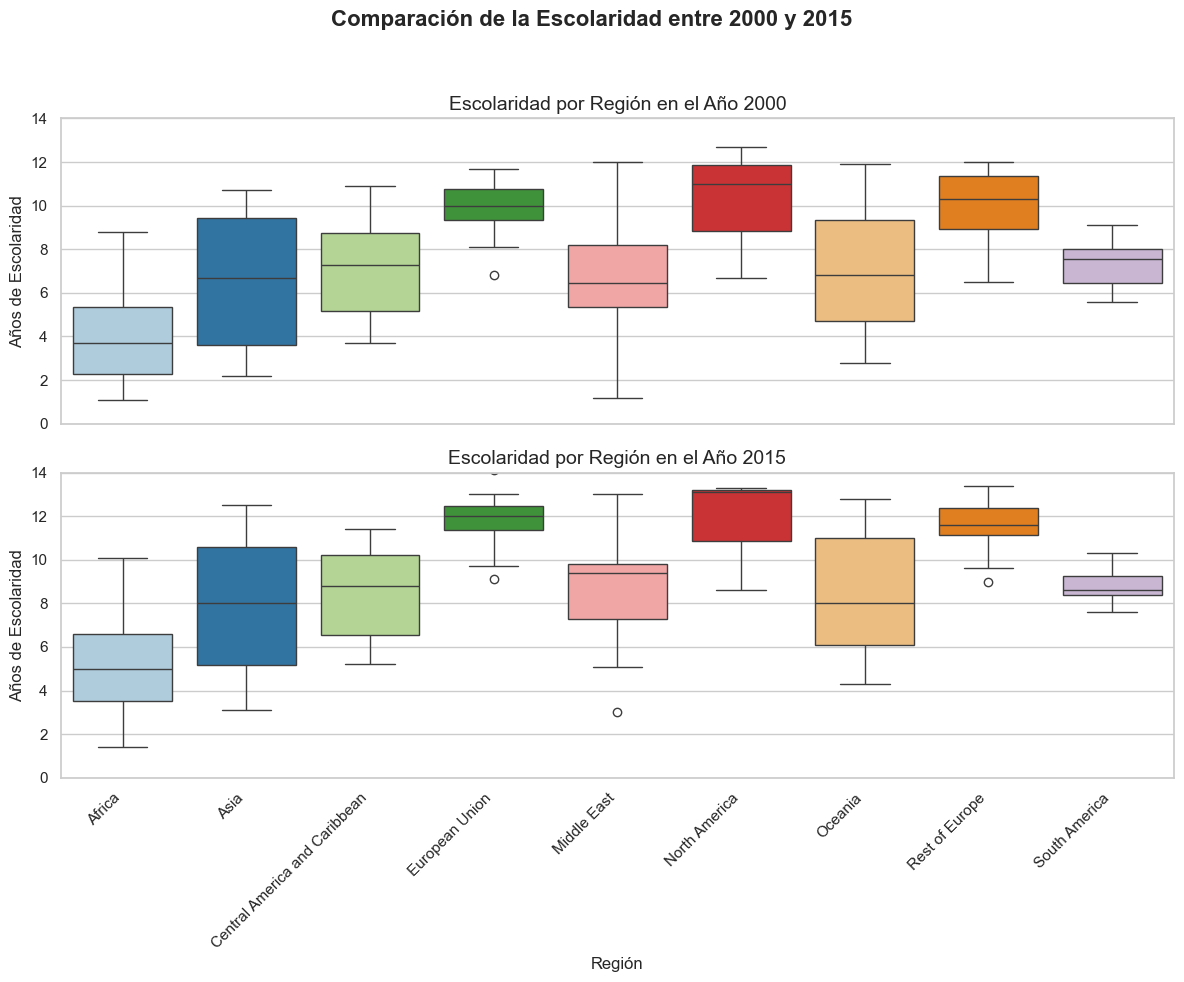

In [162]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Definir el orden de las regiones (basado en el año 2000 para consistencia)
region_order = sorted(Life_expectancy['Region'].unique())

# Crear una paleta de colores personalizada y consistente para las regiones
palette = dict(zip(region_order, sns.color_palette('Paired', n_colors=len(region_order))))

# Gráfico del año 2000
sns.boxplot(
    x='Region', 
    y='Schooling', 
    data=Life_expectancy[Life_expectancy["Year"] == 2000], 
    hue='Region',
    palette=palette,  # Usar paleta personalizada
    legend=False,
    order=region_order,  # Mantener el mismo orden
    ax=ax[0]
)
ax[0].set_title("Escolaridad por Región en el Año 2000", fontsize=14)
ax[0].set_xlabel('')  # Eliminar la etiqueta del eje x para el primer gráfico
ax[0].set_ylabel('Años de Escolaridad', fontsize=12)
ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Ocultar etiquetas x
ax[0].set_ylim(0,14)

# Gráfico del año 2015
sns.boxplot(
    x='Region', 
    y='Schooling', 
    data=Life_expectancy[Life_expectancy["Year"] == 2015], 
    hue='Region',
    palette=palette,  # Usar la misma paleta
    legend=False,
    order=region_order,  # Mantener el mismo orden
    ax=ax[1]
)
ax[1].set_title("Escolaridad por Región en el Año 2015", fontsize=14)
ax[1].set_xlabel('Región', fontsize=12)
ax[1].set_ylabel('Años de Escolaridad', fontsize=12)
ax[1].set_ylim(0,14) 

# Rotar las etiquetas del eje x para mejor legibilidad
plt.setp(ax[1].get_xticklabels(), rotation=45, ha='right')

# Título general para toda la figura
fig.suptitle("Comparación de la Escolaridad entre 2000 y 2015", fontsize=16, weight='bold')

# Ajustar el espacio entre los subgráficos
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Deja espacio para el título general

# Mostrar el gráfico
plt.show()